In [40]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchaudio.transforms as T

In [31]:
# initing dataset and check feature tensor shape
root_dir = "/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset"
vocal_dataset = VocalDataset(root_dir=root_dir)

sample_waveform, _ = vocal_dataset[0]  
print(f"Sample waveform shape: {sample_waveform.shape}")


Sample waveform shape: torch.Size([1, 128, 128])


In [59]:


class AudioAugmentation:
    def __init__(self):
        self.gain = T.Vol(gain=0.5)  
        self.noise_level = 0.01  

    def __call__(self, waveform):
        if torch.rand(1).item() > 0.5:
            waveform = self.gain(waveform)
        
        # random noise
        noise = torch.randn_like(waveform) * self.noise_level
        waveform = waveform + noise
        
        return waveform


In [60]:
class VocalDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.augment = augment  # Augmentation added here
        self.classes = ['Laryngozele', 'Normal', 'Vox senilis']
        self.files = []
        for label in self.classes:
            class_path = self.root_dir / label
            self.files += [(f, label) for f in class_path.glob('*.wav')]

        self.feature_transform = T.MelSpectrogram()
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        if self.augment:
            waveform = self.augment(waveform) # augmentation
        
        features = self.feature_transform(waveform)
        target_length = 128
        
        if features.size(2) < target_length:
            pad = target_length - features.size(2)
            features = torch.nn.functional.pad(features, (0, pad))
        else:
            features = features[:, :, :target_length]
        
        if self.transform:
            features = self.transform(features)
        
        label_idx = self.classes.index(label)  
        return features, label_idx


In [62]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_size]
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :]) 
        out = self.fc(out)
        return out


In [61]:
# initing dataset with augmentation
augmentation = AudioAugmentation()
vocal_dataset = VocalDataset(root_dir=root_dir, augment=augmentation)


In [63]:


# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
input_size = 128 * 128 
hidden_size = 128
output_size = len(vocal_dataset.classes)  
dropout_rate = 0.5  


indices = list(range(len(vocal_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_subset = Subset(vocal_dataset, train_indices)
test_subset = Subset(vocal_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


In [64]:
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [66]:

# Lists for metrics to plot
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in train_loader:
        features = features.view(features.size(0), -1, input_size)  
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        
        for features, labels in val_loader:
            features = features.view(features.size(0), -1, input_size)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Validation Accuracy for Epoch {epoch+1}: {val_accuracy:.2f}%")


Epoch [1/10], Loss: 0.8241, Accuracy: 64.49%
Validation Accuracy for Epoch 1: 66.67%
Epoch [2/10], Loss: 0.8677, Accuracy: 58.82%
Validation Accuracy for Epoch 2: 56.04%
Epoch [3/10], Loss: 0.8773, Accuracy: 58.33%
Validation Accuracy for Epoch 3: 64.73%
Epoch [4/10], Loss: 0.8542, Accuracy: 59.78%
Validation Accuracy for Epoch 4: 57.97%
Epoch [5/10], Loss: 0.8554, Accuracy: 61.23%
Validation Accuracy for Epoch 5: 67.15%
Epoch [6/10], Loss: 0.8495, Accuracy: 61.96%
Validation Accuracy for Epoch 6: 64.73%
Epoch [7/10], Loss: 0.8470, Accuracy: 61.23%
Validation Accuracy for Epoch 7: 60.87%
Epoch [8/10], Loss: 0.8509, Accuracy: 60.99%
Validation Accuracy for Epoch 8: 65.22%
Epoch [9/10], Loss: 0.8557, Accuracy: 61.71%
Validation Accuracy for Epoch 9: 64.73%
Epoch [10/10], Loss: 0.8639, Accuracy: 59.66%
Validation Accuracy for Epoch 10: 70.53%


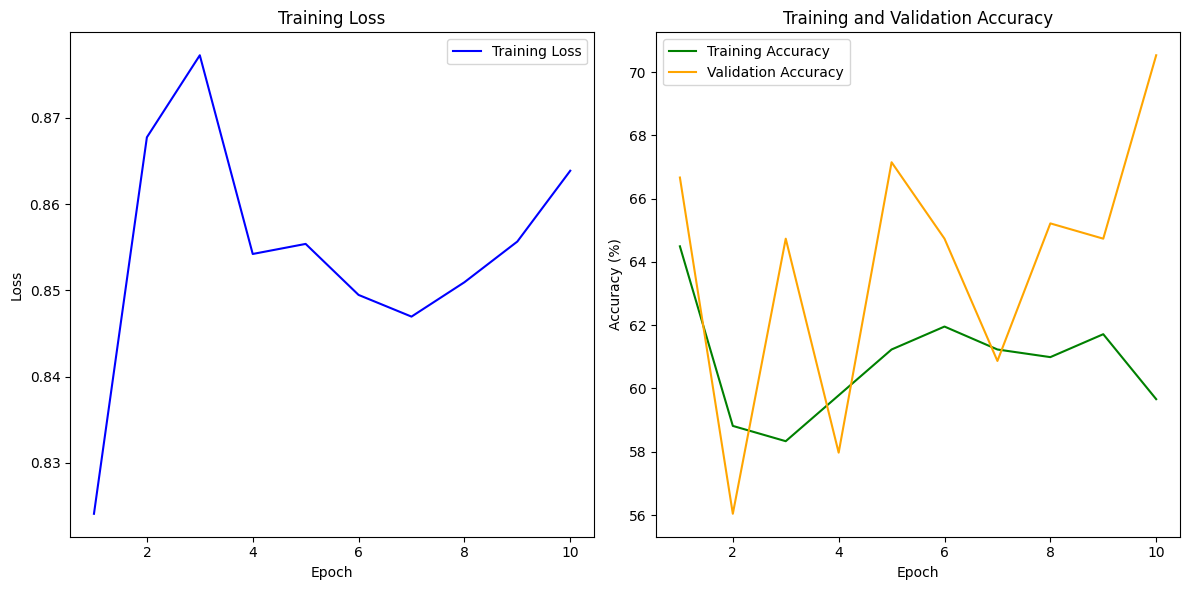

In [67]:

plt.figure(figsize=(12, 6))

# plot of Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# plot of acc
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
